In [1]:
import os
import errno
import argparse
import sys
import pickle

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

from data_utils import load_CIFAR_data, generate_partial_data, generate_bal_private_data, load_FEMNIST_data, load_MNIST_data
from FedMD import FedMD
from Neural_Networks import train_models, cnn_2layer_fc_model, cnn_3layer_fc_model

import numpy as np
from tensorflow.keras.models import clone_model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from utility import * 
from data_utils import generate_alignment_data
from Neural_Networks import remove_last_layer

## Functions and Configurations

In [25]:
# CIFAR-10 config

CANDIDATE_MODELS = {"2_layer_CNN": cnn_2layer_fc_model, 
                    "3_layer_CNN": cnn_3layer_fc_model} 

conf_file = os.path.abspath("conf/CIFAR_balance_conf.json")

with open(conf_file, "r") as f:
    conf_dict = eval(f.read())
    
    #n_classes = conf_dict["n_classes"]
    model_config = conf_dict["models"]
    pre_train_params = conf_dict["pre_train_params"]
    model_saved_dir = conf_dict["model_saved_dir"]
    model_saved_names = conf_dict["model_saved_names"]
    is_early_stopping = conf_dict["early_stopping"]
    public_classes = conf_dict["public_classes"]
    private_classes = conf_dict["private_classes"]
    n_classes = len(public_classes) + len(private_classes)
    
    emnist_data_dir = conf_dict["EMNIST_dir"]    
    N_parties = conf_dict["N_parties"]
    N_samples_per_class = conf_dict["N_samples_per_class"]
    
    N_rounds = conf_dict["N_rounds"]
    N_alignment = conf_dict["N_alignment"]
    N_private_training_round = conf_dict["N_private_training_round"]
    private_training_batchsize = conf_dict["private_training_batchsize"]
    N_logits_matching_round = conf_dict["N_logits_matching_round"]
    logits_matching_batchsize = conf_dict["logits_matching_batchsize"]
    aug = conf_dict["aug"]
    compress = conf_dict["compress"]
    
    
    result_save_dir = conf_dict["result_save_dir"]

del conf_dict, conf_file

In [2]:
#FEMNIST conifg

CANDIDATE_MODELS = {"2_layer_CNN": cnn_2layer_fc_model, 
                    "3_layer_CNN": cnn_3layer_fc_model} 

conf_file = os.path.abspath("conf/EMNIST_balance_conf.json")
with open(conf_file, "r") as f:
    conf_dict = eval(f.read())
    
    #n_classes = conf_dict["n_classes"]
    model_config = conf_dict["models"]
    pre_train_params = conf_dict["pre_train_params"]
    model_saved_dir = conf_dict["model_saved_dir"]
    model_saved_names = conf_dict["model_saved_names"]
    is_early_stopping = conf_dict["early_stopping"]
    public_classes = conf_dict["public_classes"]
    private_classes = conf_dict["private_classes"]
    n_classes = len(public_classes) + len(private_classes)
    
    emnist_data_dir = conf_dict["EMNIST_dir"]    
    N_parties = conf_dict["N_parties"]
    N_samples_per_class = conf_dict["N_samples_per_class"]
    
    N_rounds = conf_dict["N_rounds"]
    N_alignment = conf_dict["N_alignment"]
    N_private_training_round = conf_dict["N_private_training_round"]
    private_training_batchsize = conf_dict["private_training_batchsize"]
    N_logits_matching_round = conf_dict["N_logits_matching_round"]
    logits_matching_batchsize = conf_dict["logits_matching_batchsize"]
    
    
    result_save_dir = conf_dict["result_save_dir"]

In [28]:
N_samples_per_class

5

## Play 


## Load CIFAR10 data

In [3]:


X_train_CIFAR10, y_train_CIFAR10, X_test_CIFAR10, y_test_CIFAR10 \
= load_CIFAR_data(data_type="CIFAR10", 
                    standarized = True, verbose = True)

public_dataset = {"X": X_train_CIFAR10, "y": y_train_CIFAR10}


X_train_CIFAR100, y_train_CIFAR100, X_test_CIFAR100, y_test_CIFAR100 \
= load_CIFAR_data(data_type="CIFAR100",
                    standarized = True, verbose = True)

# only use those CIFAR100 data whose y_labels belong to private_classes
X_train_CIFAR100, y_train_CIFAR100 \
= generate_partial_data(X = X_train_CIFAR100, y= y_train_CIFAR100,
                        class_in_use = private_classes, 
                        verbose = True)


X_test_CIFAR100, y_test_CIFAR100 \
= generate_partial_data(X = X_test_CIFAR100, y= y_test_CIFAR100,
                        class_in_use = private_classes, 
                        verbose = True)

# relabel the selected CIFAR100 data for future convenience
for index, cls_ in enumerate(private_classes):        
    y_train_CIFAR100[y_train_CIFAR100 == cls_] = index + len(public_classes)
    y_test_CIFAR100[y_test_CIFAR100 == cls_] = index + len(public_classes)
del index, cls_

print(pd.Series(y_train_CIFAR100).value_counts())
mod_private_classes = np.arange(len(private_classes)) + len(public_classes)

print("="*60)
#generate private data
private_data, total_private_data\
=generate_bal_private_data(X_train_CIFAR100, y_train_CIFAR100,      
                            N_parties = N_parties,           
                            classes_in_use = mod_private_classes, 
                            N_samples_per_class = N_samples_per_class, 
                            data_overlap = False)

print("="*60)
X_tmp, y_tmp = generate_partial_data(X = X_test_CIFAR100, y= y_test_CIFAR100,
                                        class_in_use = mod_private_classes, 
                                        verbose = True)
private_test_data = {"X": X_tmp, "y": y_tmp}
del X_tmp, y_tmp

parties = []
if model_saved_dir is None:
    for i, item in enumerate(model_config):
        model_name = item["model_type"]
        model_params = item["params"]
        tmp = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                            input_shape=(32,32,3),
                                            **model_params)
        print("model {0} : {1}".format(i, model_saved_names[i]))
        # print(tmp.summary())
        parties.append(tmp)


X_train shape : (50000, 32, 32, 3)
X_test shape : (10000, 32, 32, 3)
y_train shape : (50000,)
y_test shape : (10000,)
X_train shape : (50000, 32, 32, 3)
X_test shape : (10000, 32, 32, 3)
y_train shape : (50000,)
y_test shape : (10000,)
X shape : (3000, 32, 32, 3)
y shape : (3000,)
X shape : (600, 32, 32, 3)
y shape : (600,)
10    500
15    500
14    500
12    500
13    500
11    500
dtype: int64
X shape : (600, 32, 32, 3)
y shape : (600,)
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-08-01 17:57:27.940421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-01 17:57:27.942579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/gadmohamed/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


model 0 : CNN_128_256
model 1 : CNN_128_384
model 2 : CNN_128_512
model 3 : CNN_256_256
model 4 : CNN_256_512
model 5 : CNN_64_128_256
model 6 : CNN_64_128_192
model 7 : CNN_128_192_256
model 8 : CNN_128_128_128
model 9 : CNN_128_128_192
model 10 : CNN_128_256
model 11 : CNN_128_384
model 12 : CNN_128_512
model 13 : CNN_256_256
model 14 : CNN_256_512
model 15 : CNN_64_128_256
model 16 : CNN_64_128_192
model 17 : CNN_128_192_256
model 18 : CNN_128_128_128
model 19 : CNN_128_128_192


## Load FASHION MNIST dataset

In [3]:

X_train_MNIST, y_train_MNIST, X_test_MNIST, y_test_MNIST \
= load_MNIST_data(standarized = True, verbose = True)

public_dataset = {"X": X_train_MNIST, "y": y_train_MNIST}


X_train_EMNIST, y_train_EMNIST, X_test_EMNIST, y_test_EMNIST \
= load_FEMNIST_data(standarized = True, verbose = True)

y_train_EMNIST = y_train_EMNIST + len(public_classes)
y_test_EMNIST = y_test_EMNIST + len(public_classes)

print("y train femnist unique:", np.unique(y_train_EMNIST))
print("y test femnist unique:", np.unique(y_test_EMNIST)) 
print("private classes:", private_classes)

#generate private data
private_data, total_private_data \
= generate_bal_private_data(X_train_EMNIST, y_train_EMNIST, 
                            N_parties = N_parties,             
                            classes_in_use = private_classes, 
                            N_samples_per_class = N_samples_per_class, 
                            data_overlap = False)

X_tmp, y_tmp = generate_partial_data(X = X_test_EMNIST, y= y_test_EMNIST, 
                                        class_in_use = private_classes, verbose = True)
private_test_data = {"X": X_tmp, "y": y_tmp}
del X_tmp, y_tmp

parties = []
if model_saved_dir is None:
    for i in range(N_parties):

        item = np.random.choice(model_config)
        model_name = item["model_type"]
        model_params = item["params"]
        tmp = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                            input_shape=(28,28),
                                            **model_params)
        # print("model {0} : {1}".format(i, model_saved_names[i]))
        # print(tmp.summary())
        parties.append(tmp)
        
        del model_name, model_params, tmp
    #END FOR LOOP
#     pre_train_result = train_models(parties, 
#                                     X_train_MNIST, y_train_MNIST, 
#                                     X_test_MNIST, y_test_MNIST,
#                                     save_dir = model_saved_dir, save_names = model_saved_names,
#                                     early_stopping = is_early_stopping,
#                                     **pre_train_params
#                                    )
else:
    dpath = os.path.abspath(model_saved_dir)
    model_names = os.listdir(dpath)
    for name in model_names:
        tmp = None
        tmp = load_model(os.path.join(dpath ,name))
        parties.append(tmp)


MNIST dataset ... 
X_train shape : (60000, 28, 28)
X_test shape : (10000, 28, 28)
y_train shape : (60000,)
y_test shape : (10000,)
shape: (60000,)
unique: [0 1 2 3 4 5 6 7 8 9]
EMNIST-letter dataset ... 
X_train shape : (60000, 28, 28)
X_test shape : (10000, 28, 28)
y_train shape : (60000,)
y_test shape : (10000,)
y train femnist unique: [ 9 10 11 12 13 14 15 16 17 18]
y test femnist unique: [ 9 10 11 12 13 14 15 16 17 18]
private classes: [10, 11, 12, 13, 14, 15]
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-08-11 22:12:23.449555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-11 22:12:23.449919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/gadmohamed/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
size_of(public_dataset['X'][:500]), size_of(parties[0]), len(parties)

(3136.0, 7914.496, 20)

# Training

In [18]:
new_total_private_data = {}
new_total_private_data['X'] = np.concatenate([p['X'] for p in private_data ], axis = 0)
new_total_private_data['y'] = np.concatenate([p['y'] for p in private_data ], axis = 0)

print(private_data[0]['X'].shape, total_private_data['X'].shape, new_total_private_data['X'].shape)

(30, 28, 28) (600, 28, 28) (600, 28, 28)


In [5]:
input_shape = private_data[0]["X"].shape[1:]
# [0.5483333468437195, 0.5421666502952576, 0.6263333559036255, 0.4596666693687439, 0.5808333158493042, 0.6393333077430725, 0.6313333511352539, 0.5663333535194397, 0.5171666741371155, 0.503333330154419]

local_accuracies = [] 
for i in range(len(private_data)):

    tf.keras.backend.clear_session()
    item = model_config[0]
    model_name = item["model_type"]
    model_params = item["params"]
    model_ub = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                        input_shape=input_shape,
                                        **model_params)
    model_ub.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
                        loss = "sparse_categorical_crossentropy", 
                        metrics = ["accuracy"])
    ub_history = model_ub.fit(private_data[i]['X'], private_data[i]['y'],
                    batch_size = 30, epochs = 30, shuffle=True, verbose = False, 
                    validation_data = [private_test_data["X"], private_test_data["y"]],
                    callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=7, restore_best_weights=True)])

    local_accuracies.append(ub_history.history["val_accuracy"])
    print("final accuracy:", ub_history.history["val_accuracy"][-1])


/Users/gadmohamed/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-08-11 22:13:30.311728: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-11 22:13:30.721381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:13:32.263793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.3738333284854889


2023-08-11 22:14:42.932857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:14:44.216782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.47316667437553406


2023-08-11 22:16:29.173915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:16:30.687625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5299999713897705


2023-08-11 22:17:51.113109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:17:51.716606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.4569999873638153


2023-08-11 22:19:26.758365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:19:27.923400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.32883334159851074


2023-08-11 22:20:33.712263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:20:34.301590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.3621666729450226


2023-08-11 22:22:04.189711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:22:04.791776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5366666913032532


2023-08-11 22:23:11.298539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:23:11.907083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5173333287239075


2023-08-11 22:24:48.351392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:24:49.491230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.6244999766349792


2023-08-11 22:25:44.814058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:25:46.124887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.4411666691303253


2023-08-11 22:27:25.968349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:27:26.602980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.4698333442211151


2023-08-11 22:29:18.691751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:29:19.262621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5770000219345093


2023-08-11 22:30:36.101371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:30:37.261508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.35899999737739563


2023-08-11 22:31:36.428143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:31:36.980460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.4101666808128357


2023-08-11 22:32:53.837465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:32:54.421759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.46016666293144226


2023-08-11 22:34:07.514523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:34:07.986119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5331666469573975


2023-08-11 22:35:20.062641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:35:21.238670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.2601666748523712


2023-08-11 22:36:56.939733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:36:57.384239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5133333206176758


2023-08-11 22:39:01.666266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:39:02.108028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.42933332920074463


2023-08-11 22:40:36.900499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-11 22:40:37.319651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.3894999921321869


In [13]:
np.mean([acc[-1] for acc in local_accuracies])

0.4523166656494141

average: 0.4523166656494141


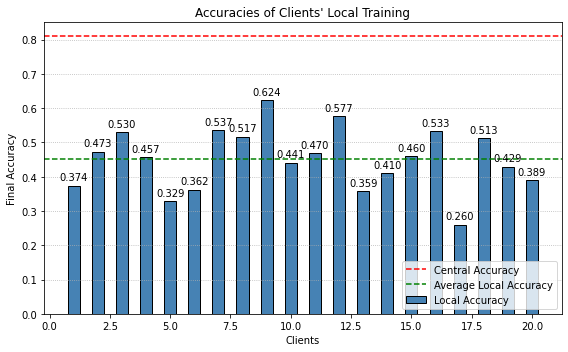

In [25]:
import matplotlib.pyplot as plt

# Data for the bar plot
accuracies = [0.5483333468437195, 0.5421666502952576, 0.6263333559036255, 0.4596666693687439, 0.5808333158493042, 0.6393333077430725, 0.6313333511352539, 0.5663333535194397, 0.5171666741371155, 0.503333330154419]
accuracies = [acc[-1] for acc in local_accuracies]
# Clients for the x-axis (assuming one accuracy value per client)
clients = range(1, len(accuracies) + 1)

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the bar chart with custom colors, edgecolor, and width
bars = ax.bar(clients, accuracies, color='steelblue', edgecolor='black', width=0.5, label = 'Local Accuracy')

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Set x and y axis labels and title
ax.set_xlabel('Clients')
ax.set_ylabel('Final Accuracy')
ax.set_title('Accuracies of Clients\' Local Training')

# Add a horizontal line at accuracy 70 to mark it as the central accuracy
central_avg_acc = np.mean([acc[-1] for acc in central_trials])
ax.axhline(y=central_avg_acc, color='red', linestyle='--', label='Central Accuracy')

# Add a horizontal line for the average accuracy local 
ax.axhline(y=sum(accuracies)/len(accuracies), color='green', linestyle='--', label='Average Local Accuracy')

print("average:", sum(accuracies)/len(accuracies))
# Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
plt.tight_layout()

# Add a legend with position right bottom
plt.legend(loc='lower right')

# Save the plot as a high-quality PDF
plt.savefig('local_central.pdf', dpi=300)

# Show the plot
plt.show()


In [21]:
    
central_trials = [] 
for i in range(5) : 
    tf.keras.backend.clear_session()
    input_shape = private_data[0]["X"].shape[1:]

    cbs = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=7, restore_best_weights=True)]
    cbs = [] 

    item = model_config[0]
    model_name = item["model_type"]
    model_params = item["params"]
    model_ub = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                        input_shape=input_shape,
                                        **model_params)
    model_ub.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
                        loss = "sparse_categorical_crossentropy", 
                        metrics = ["accuracy"])
    print("shpae of private data:", private_data[0]["X"].shape)
    ub_history = model_ub.fit(new_total_private_data['X'], new_total_private_data['y'],
                    batch_size = 30, epochs = 40, shuffle=True, verbose = True, 
                    validation_data = [private_test_data["X"], private_test_data["y"]],
                    callbacks=[cbs])

    central_trials.append(ub_history.history["val_accuracy"])
    print("final accuracy:", ub_history.history["val_accuracy"][-1])


/Users/gadmohamed/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


shpae of private data: (30, 28, 28)
Epoch 1/40


2023-08-11 22:50:34.505245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 3.9085 - accuracy: 0.5383

2023-08-11 22:50:38.372358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 10s 459ms/step - loss: 3.9085 - accuracy: 0.5383 - val_loss: 1.4930 - val_accuracy: 0.5148
Epoch 2/40
20/20 [==============================] - 10s 496ms/step - loss: 1.3443 - accuracy: 0.7967 - val_loss: 2.3889 - val_accuracy: 0.2138
Epoch 3/40
20/20 [==============================] - 8s 419ms/step - loss: 0.8844 - accuracy: 0.8250 - val_loss: 2.7279 - val_accuracy: 0.1667
Epoch 4/40
20/20 [==============================] - 8s 418ms/step - loss: 0.5324 - accuracy: 0.8650 - val_loss: 3.4125 - val_accuracy: 0.1667
Epoch 5/40
20/20 [==============================] - 9s 450ms/step - loss: 0.4867 - accuracy: 0.8933 - val_loss: 4.1790 - val_accuracy: 0.1667
Epoch 6/40
20/20 [==============================] - 8s 422ms/step - loss: 0.4392 - accuracy: 0.9067 - val_loss: 5.4352 - val_accuracy: 0.1667
Epoch 7/40
20/20 [==============================] - 8s 402ms/step - loss: 0.3335 - accuracy: 0.9133 - val_loss: 5.6761 - val_accuracy: 0.1667
Epoch 8/40
20/2

2023-08-11 22:55:07.323244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 3.6706 - accuracy: 0.5500

2023-08-11 22:55:09.818225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 9s 425ms/step - loss: 3.6706 - accuracy: 0.5500 - val_loss: 1.4718 - val_accuracy: 0.3995
Epoch 2/40
20/20 [==============================] - 5s 260ms/step - loss: 1.2722 - accuracy: 0.7483 - val_loss: 2.5147 - val_accuracy: 0.1867
Epoch 3/40
20/20 [==============================] - 7s 382ms/step - loss: 1.1319 - accuracy: 0.8300 - val_loss: 4.0447 - val_accuracy: 0.1667
Epoch 4/40
20/20 [==============================] - 8s 407ms/step - loss: 0.7634 - accuracy: 0.8583 - val_loss: 4.8695 - val_accuracy: 0.1905
Epoch 5/40
20/20 [==============================] - 7s 367ms/step - loss: 0.5466 - accuracy: 0.8983 - val_loss: 4.5242 - val_accuracy: 0.2132
Epoch 6/40
20/20 [==============================] - 8s 409ms/step - loss: 0.3399 - accuracy: 0.9200 - val_loss: 6.2862 - val_accuracy: 0.1667
Epoch 7/40
20/20 [==============================] - 6s 285ms/step - loss: 0.3756 - accuracy: 0.9083 - val_loss: 5.5360 - val_accuracy: 0.2318
Epoch 8/40
20/20 

2023-08-12 01:12:47.953607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 2.4880 - accuracy: 0.6000

2023-08-12 01:12:51.363178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 2824s 149s/step - loss: 2.4880 - accuracy: 0.6000 - val_loss: 1.5098 - val_accuracy: 0.3105
Epoch 2/40
20/20 [==============================] - 2091s 110s/step - loss: 0.9515 - accuracy: 0.7950 - val_loss: 2.1577 - val_accuracy: 0.2213
Epoch 3/40
20/20 [==============================] - 1985s 104s/step - loss: 0.8149 - accuracy: 0.8500 - val_loss: 3.6286 - val_accuracy: 0.1667
Epoch 4/40
20/20 [==============================] - 3100s 163s/step - loss: 0.8642 - accuracy: 0.8367 - val_loss: 4.4426 - val_accuracy: 0.1667
Epoch 5/40
20/20 [==============================] - 3095s 163s/step - loss: 0.9958 - accuracy: 0.8617 - val_loss: 4.9547 - val_accuracy: 0.1667
Epoch 6/40
20/20 [==============================] - 1937s 102s/step - loss: 0.5672 - accuracy: 0.8967 - val_loss: 6.0699 - val_accuracy: 0.1667
Epoch 7/40
20/20 [==============================] - 1864s 98s/step - loss: 0.5100 - accuracy: 0.9150 - val_loss: 5.4612 - val_accuracy: 0.1667
Epoc

2023-08-12 08:56:20.828556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 2.5176 - accuracy: 0.6000

2023-08-12 08:56:22.745402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 7s 273ms/step - loss: 2.5176 - accuracy: 0.6000 - val_loss: 1.6214 - val_accuracy: 0.4685
Epoch 2/40
20/20 [==============================] - 4s 191ms/step - loss: 1.4839 - accuracy: 0.7817 - val_loss: 2.5155 - val_accuracy: 0.1770
Epoch 3/40
20/20 [==============================] - 4s 187ms/step - loss: 1.1037 - accuracy: 0.8217 - val_loss: 3.0551 - val_accuracy: 0.2020
Epoch 4/40
20/20 [==============================] - 5s 251ms/step - loss: 0.7116 - accuracy: 0.8750 - val_loss: 3.6250 - val_accuracy: 0.2733
Epoch 5/40
20/20 [==============================] - 5s 253ms/step - loss: 0.6313 - accuracy: 0.9017 - val_loss: 4.2772 - val_accuracy: 0.1667
Epoch 6/40
20/20 [==============================] - 4s 194ms/step - loss: 0.3591 - accuracy: 0.9217 - val_loss: 4.5837 - val_accuracy: 0.1668
Epoch 7/40
20/20 [==============================] - 5s 262ms/step - loss: 0.2742 - accuracy: 0.9267 - val_loss: 5.1891 - val_accuracy: 0.1667
Epoch 8/40
20/20 

2023-08-12 08:59:20.285116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 3.0497 - accuracy: 0.5833

2023-08-12 08:59:22.285031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 8s 413ms/step - loss: 3.0497 - accuracy: 0.5833 - val_loss: 1.5370 - val_accuracy: 0.4047
Epoch 2/40
20/20 [==============================] - 8s 393ms/step - loss: 1.6674 - accuracy: 0.7667 - val_loss: 3.1496 - val_accuracy: 0.2217
Epoch 3/40
20/20 [==============================] - 6s 298ms/step - loss: 1.1046 - accuracy: 0.8217 - val_loss: 3.1573 - val_accuracy: 0.1667
Epoch 4/40
20/20 [==============================] - 8s 413ms/step - loss: 0.8991 - accuracy: 0.8333 - val_loss: 3.7584 - val_accuracy: 0.2215
Epoch 5/40
20/20 [==============================] - 8s 424ms/step - loss: 0.4868 - accuracy: 0.8983 - val_loss: 4.6733 - val_accuracy: 0.1993
Epoch 6/40
20/20 [==============================] - 8s 411ms/step - loss: 0.4236 - accuracy: 0.9067 - val_loss: 5.3082 - val_accuracy: 0.1678
Epoch 7/40
20/20 [==============================] - 8s 424ms/step - loss: 0.3033 - accuracy: 0.9317 - val_loss: 5.8970 - val_accuracy: 0.2035
Epoch 8/40
20/20 

In [24]:
np.mean([acc[-1] for acc in central_trials]), [acc[-1] for acc in central_trials]

(0.8098000049591064,
 [0.8218333125114441,
  0.8196666836738586,
  0.8118333220481873,
  0.7891666889190674,
  0.8065000176429749])

In [7]:
np.mean(local_trials), np.std(local_trials)

NameError: name 'local_trials' is not defined

In [23]:
np.mean(central_trials), np.std(central_trials), central_trials

(0.49766083560884,
 0.27189877306606575,
 [[0.5148333311080933,
   0.21383333206176758,
   0.1666666716337204,
   0.1666666716337204,
   0.1666666716337204,
   0.1666666716337204,
   0.1666666716337204,
   0.1666666716337204,
   0.20516666769981384,
   0.1666666716337204,
   0.20533333718776703,
   0.1666666716337204,
   0.16699999570846558,
   0.1665000021457672,
   0.2134999930858612,
   0.3986666798591614,
   0.36683332920074463,
   0.43033334612846375,
   0.5625,
   0.6355000138282776,
   0.6215000152587891,
   0.6726666688919067,
   0.749666690826416,
   0.6791666746139526,
   0.7103333473205566,
   0.7528333067893982,
   0.6464999914169312,
   0.7541666626930237,
   0.7941666841506958,
   0.793666660785675,
   0.8071666955947876,
   0.8109999895095825,
   0.8111666440963745,
   0.8165000081062317,
   0.8195000290870667,
   0.8116666674613953,
   0.8205000162124634,
   0.8149999976158142,
   0.8243333101272583,
   0.8218333125114441],
  [0.3995000123977661,
   0.18666666746139526,